## Module 07: Advection-Diffusion Problems â€“ Infiltration Into Soils

### 1. Introduction and Background

In this notebook, we develop a model for the infiltration of water into an unsaturated soil that treats the process as an advection-dispersion-like problem. As alluded to in the class, this is __not a particularly realistic assumption__, but we nevertheless produce soil moisture curves that look plausible. Moreover, in class and below, we go through the gymnastics of the assumptions that we have to make to be able to pose the infiltration problem as one of advection-dispersion. 

In our treatment of infiltration as an advection-dispersion process, we make the following assumptions about the origin of the advection and dispersion (diffusion) parts of the process:

1. Advection arises from the force of gravity pulling the wetting front into the soil
2. Dispersion arises from capillary forces associated with the wetting of a pore network that is assumed to be functionally similar to a "bundle of capillary tubes."

Following these assumptions, we wrote down the 1-D, mixed $h-\theta$ Richards equation as follows: 

$$
\frac{\partial \theta}{\partial t} = \frac{\partial}{\partial z}\left[ K(\theta)\left( \frac{\partial \psi}{\partial z} + 1 \right) \right]
$$

Expanding the terms on the right hand side of the equation further gives us:

$$
\frac{\partial \theta}{\partial t} = \frac{\partial}{\partial z}\left[ K(\theta)\frac{\partial \psi}{\partial z} + K(\theta) \right]
$$

We immediately see two complications of the Richards equation that make it particularly problematic to solve using the tools we've developed so far. First, the partial differential equation is nonlinear in form as the hydraulic conductivity $K(\theta)$ depends on the very function $\theta$ that we are solving for. Second, we have what's known as a closure problem in that we have two state variables that we are solving for, the volumetric soil moisture ($\theta$) and the soil matric potential ($\psi$).  

The second complication we circumvent by using a constitutive relationship between $\psi$ and $\theta$ in the form of a soil characteristic curve such as the Brooks-Corey or van Genuchten equations. These parameterizations give us functional relationships between $\psi$, $\theta$, and $K(\theta)$ that depend on characteristics of the soil that can, in principle, be measured or estimated in the lab. 

The former complication implies that we will need to use an interative solution to solve the equation that uses a trial value of $\theta$ to compute $K(\theta)$ and then iterates until the left- and right-hand side of the equations balance (it's more complicated than this, but this is a good conceptual start). A further complication arises as a result of our use of the soil-water characteristic curves in that they are highly nonlinear functions, particularly at high and low values of soil moisture. As such, small errors in $\theta$ can produce large errors in $\psi$, meaning that we may be iterating on $\theta$ for a while. 

In this notebook, ___we will sidestep the issue of the nonlinearity in the partial differential equation entirely by making two (unrealistic) assumptions.___ First off, an important insight is that, because of our soil-water characteristic curves, we can eliminate the dependency on $\psi$ because a result of those soil water characteristic curves is that we can derive a "diffusivity" of the infiltration problem as follows:

$$
K(\theta) \equiv D(\theta)\frac{\partial \theta}{\partial \psi}
$$

and 

$$
D(\theta) = K(\theta)\frac{\partial \psi}{\partial \theta}
$$


where $\partial \theta / \partial \psi$ is just the derivative of our constitutive relationship (it's just an analytical equation that's given for parameterizations like Brooks-Corey and van Genuchten). If we insert this equation into the expanded Richards equation above, we get:

$$
\frac{\partial \theta}{\partial t} = \frac{\partial}{\partial z}\left[ D(\theta)\frac{\partial \theta}{\partial \psi} \frac{\partial \psi}{\partial z} + K(\theta)  \right]
$$

This then simplifies to:

$$
\frac{\partial \theta}{\partial t} = \frac{\partial}{\partial z}\left[ D(\theta)\frac{\partial \theta}{\partial z} + K(\theta)  \right]
$$

Now, we will make two assumptions that will allow us to cast this problem as an advection-dispersion like problem. These assumptions are:

1. The soil water diffusivity is a constant and just equal to an effective hydraulic conductivity times the slope of the soil water retention curve at a particular value of soil moisture. And,
2. The unsaturated hydraulic conductivity is just the product of the same effective hydraulic conductivity from assumption one and the soil moisture itself.

Stated mathematically:

$$ 
D(\theta) = K_{\mathrm{eff}}\cdot\frac{\partial \psi}{\partial \theta} = D_{\mathrm{eff}} = \mathrm{const.}
$$

and 

$$
K(\theta) = K_{\mathrm{eff}}\cdot\theta
$$

Inserting these assumptions into the Richards equation gives us: 

$$
\frac{\partial \theta}{\partial t} = \frac{\partial}{\partial z}\left[ D\frac{\partial \theta}{\partial z} + K\cdot\theta\right]
$$

which simplifies to: 

$$
\frac{\partial \theta}{\partial t} = D_{\mathrm{eff}}\frac{\partial^2 \theta}{\partial z^2} + K_{\mathrm{eff}}\frac{\partial \theta}{\partial z}
$$

This now takes the form of an advection-dispersion function where $D_{\mathrm{eff}}$ accounts for the diffusivity and the advection speed is effectively $K_{\mathrm{eff}}$. We can now use the QUICK solution to solve for the soil moisture at the $j$ location and the $i+1$ time step, $\theta_j^{i+1}$ as follows: 

$$
\theta_j^{i+1} = \theta_j^i - c\left(\frac{1}{8}\theta_{j-2}^i - \frac{7}{8}\theta_{j-1}^i + \frac{3}{8}\theta_j^i + \frac{3}{8}\theta_{j+1}^i\right) + \alpha\left(\theta_{j-1}^i - 2\theta_j^i + \theta_{j+1}^i\right)
$$

where $c$ is the Courant condition $c = K_{\mathrm{eff}}\cdot\Delta t/\Delta z$ and $\alpha$ is the diffusion number $\alpha = D_{\mathrm{eff}}\cdot\Delta t/\Delta z^2$. What remains is to define the boundary condition at the top of the soil column that we are modeling.

### 2. Model Setup and Prep

In [1]:
import numpy as np
import matplotlib.pyplot as plt

zmin = 0.0    # Elevation at the top of the soil column [cm]
zmax = 1000.0 # Elevation at the bottom of the soil column (by convention positive is into the Earth) [cm]

dz = 5.0 # Layer thickness for solving the advection-dispersion equation

t0 = 0.0 # Initial time of simulation [hr]
tf = 2000.0 # Final time of simulation [hr]

dt = 5.0 # Initial time step [hr]. NOTE: This may be changed below to satisfy the stability conditions of the QUICK method

Keff = 0.72e-4*3600 # Effective hydraulic conductivity in cm/hr
dhdtheta = 8 # Slope of the soil-water characteristics curve [cm]

Deff = Keff*dhdtheta

### 3. Change $\Delta t$ if Necessary

The QUICK method imposes two inequality conditions relating the Courant condition and diffusion number. Here we compute them with the initial values of `dz`, `dt`, `Keff`, and `Deff` set above. If the inequality conditions are not satisfied, we assume that the user would respond by reducing the time step first. In this case, we halve the initial time step, recompute the Courant condition and diffusion number, and repeat. This process repeats until the inequality conditions are met. 

In [2]:
flag = 0 # This is used as a stopping criteria to break out of the while loop once the inequality conditions are met
count = 1 # Just a counter variable to see how many iterations we've performed (not used)

while (flag==0): 
    
    c = Keff*dt/dz # Calculate the Courant condition
    alpha = Deff*dt/(dz**2) # Calculate the diffusion number 
    
    if((c**2 <= 2*alpha) and ((alpha + c/4) <= 0.5)): # If inequality conditions are met
        flag = 1 # Set the flag = 1 and keep the current dt. 
    else: # If not
        dt = dt/2 # Halve the value of the time step and repeat
        
    count = count + 1 # Iterate counter
    
print('Final timestep = '+str(dt)) # Report the final time step

Final timestep = 5.0


### 4. Setup the Spatial and Temporal Domains

In [3]:
z = np.arange(dz/2, zmax, dz) # This is the vertical "mesh" or "grid"
Nz = z.size # Compute the total number of layers

In [4]:
t = np.arange(t0, tf, dt) # This is the time vector
Nt = t.size # Compute the total number of time steps

### 5. Define Initial Condition

Here we assume that the initial soil moisture is 20% everywhere in the soil profile initially.

In [5]:
theta0 = 0.2 * np.ones((Nz)) # Set initial soil moisture to 0.2 everywhere

### 6. Define Boundary Condition

Our boundary condition will consist of saturated conditions $\theta = 1$ at the top during the entire simulation. 

In [6]:
thetatop = np.ones((Nt))

### 7. Create a Storage Container for Simulated Soil Moisture Profiles

In [7]:
theta = np.zeros((Nz,Nt))

### 8. Perform the Modeling Step

In [8]:
for i in np.arange(Nt): # Loop through time first
    
    if(i==0): # If the first time step, the initial soil moisture profile is the one set above
        theta_i = theta0
    else: # At subsequent time steps, the initial soil moisture is just the soil moisture simulated at the previous time
        theta_i = theta[:,i-1]
        
    # Create a dummy storage container for the simulated soil moisture at time step i+1
    theta_ip1 = np.zeros((Nz))
    
    # Loop through the layers
    for j in np.arange(Nz):
        
        if(j==0): # At the very top the soil moisture is equal to that at the boundary condition (thetatop)
            theta_ip1[j] = thetatop[i]
        elif(j==1): # At j=1, there is no j-2, so we assume the value at j-2 is the same as the value at j-1
            theta_ip1[j] = theta_i[j] - c*((1/8)*theta_i[j] - (7/8)*theta_i[j-1] + (3/8)*theta_i[j] 
                + (3/8)*theta_i[j+1]) + alpha*(theta_i[j-1] - 2*theta_i[j] + theta_i[j+1])
        elif(j==(Nz-1)): # In the bottom layer there is no j+1 layer, so we assume the value at j+1 is equal to the 
                         # value of theta at j
            theta_ip1[j] = theta_i[j] - c*((1/8)*theta_i[j-2] - (7/8)*theta_i[j-1] + (3/8)*theta_i[j] 
                + (3/8)*theta_i[j]) + alpha*(theta_i[j-1] - 2*theta_i[j] + theta_i[j])
        else: # Everywhere else, use the standard QUICK solution
            theta_ip1[j] = theta_i[j] - c*((1/8)*theta_i[j-2] - (7/8)*theta_i[j-1] + (3/8)*theta_i[j] 
                + (3/8)*theta_i[j+1]) + alpha*(theta_i[j-1] - 2*theta_i[j] + theta_i[j+1])
    
    # Store the simulated soil moisture profile for this time step. This will become the initial soil moisture 
    # profile at the next time step
    theta[:,i] = theta_ip1


### 9. Plot Results

Here we want to show an informative, but not overwhelming, number of soil moisture profiles during the course of our simulation. In this case, I am plotting the soil moisture profile at the beginning and every subsequent increment of `50*dt` time steps. This gives us a nice depiction of how our wetting front of soil moisture evolves over time under the influence of both advection and dispersion.  

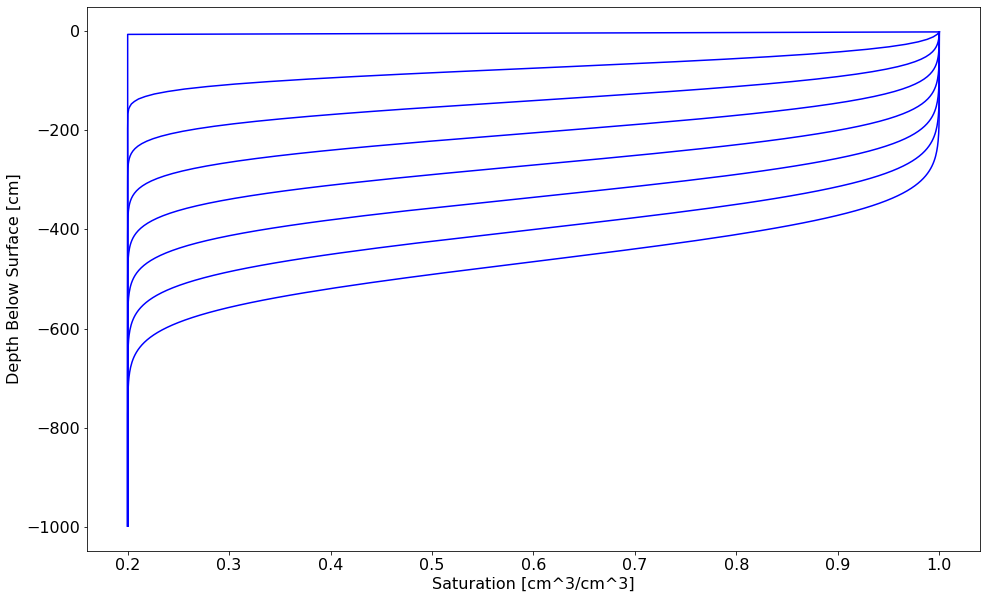

In [9]:
plt.rcParams.update({'font.size': 16}) # Change font size to something legible
plt.figure(figsize=(16,10)) # Create a figure

for p in np.arange(0,Nt,50): # Loop through and plot every 50th simulated soil moisture profile as a blue line 
    plt.plot(theta[:,p],-z,'b') # Note sign of z... we're now plotting z as negative into the soil surface
    
# Add labels with units
plt.xlabel('Saturation [cm^3/cm^3]')
plt.ylabel('Depth Below Surface [cm]')
plt.show()